# Benchmarking Different Classification Algorithms

This notebook compares the performance of different classification algorithms:
1. Multinomial Naïve Bayes
2. Decision Tree
3. Random Forest
4. Support Vector Machine (SVM)
5. Logistic Regression

In [54]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel
from typing import Dict, List, Tuple

In [55]:
# Define data models using Pydantic
class ModelMetrics(BaseModel):
    name: str
    accuracy: float
    training_time: float
    cross_val_scores: List[float]
    confusion_matrix: List[List[int]]


class BenchmarkResults(BaseModel):
    models: Dict[str, ModelMetrics]

In [56]:
# Load and preprocess data
df = pd.read_csv("Labelled_Test_Cases.csv", encoding="latin1")
columns_to_keep = ["v1", "v2"]
df = df[columns_to_keep]

# Print basic dataset info
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df.v1.value_counts())

Dataset Shape: (3000, 2)

Class Distribution:
v1
Pos    2100
Neg     900
Name: count, dtype: int64


In [57]:
def create_pipeline(classifier):
    """Create a sklearn pipeline with vectorizer, transformer and classifier"""
    return Pipeline(
        [
            ("vectorizer", CountVectorizer()),
            ("transformer", TfidfTransformer()),
            ("classifier", classifier),
        ]
    )


def evaluate_model(
    model, X_train, X_test, y_train, y_test, model_name: str
) -> ModelMetrics:
    """Evaluate a model and return its metrics"""
    # Train and measure time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions).tolist()
    cv_scores = cross_val_score(model, X_train, y_train, cv=5).tolist()

    return ModelMetrics(
        name=model_name,
        accuracy=accuracy,
        training_time=training_time,
        cross_val_scores=cv_scores,
        confusion_matrix=conf_matrix,
    )

In [58]:
# Define classifiers with their hyperparameters
classifiers = {
    "Multinomial NB": MultinomialNB(alpha=1.0),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
}

# Prepare data
corpus = df["v2"].tolist()
X_train, X_test, y_train, y_test = train_test_split(
    corpus, df["v1"], test_size=0.3, random_state=42
)

# Run benchmarks
results = BenchmarkResults(models={})

for name, clf in classifiers.items():
    print(f"\nEvaluating {name}...")
    pipeline = create_pipeline(clf)
    metrics = evaluate_model(pipeline, X_train, X_test, y_train, y_test, name)
    results.models[name] = metrics

    print(f"Accuracy: {metrics.accuracy:.4f}")
    print(f"Training Time: {metrics.training_time:.2f} seconds")
    print(
        f"Cross-validation Scores: {np.mean(metrics.cross_val_scores):.4f} ± {np.std(metrics.cross_val_scores):.4f}"
    )


Evaluating Multinomial NB...
Accuracy: 0.8000
Training Time: 0.04 seconds
Cross-validation Scores: 0.8124 ± 0.0079

Evaluating Decision Tree...
Accuracy: 0.9222
Training Time: 0.07 seconds
Cross-validation Scores: 0.9090 ± 0.0063

Evaluating Random Forest...
Accuracy: 0.9044
Training Time: 0.81 seconds
Cross-validation Scores: 0.9019 ± 0.0109

Evaluating SVM...
Accuracy: 0.9233
Training Time: 0.35 seconds
Cross-validation Scores: 0.9133 ± 0.0109

Evaluating Logistic Regression...
Accuracy: 0.8667
Training Time: 0.05 seconds
Cross-validation Scores: 0.8714 ± 0.0113


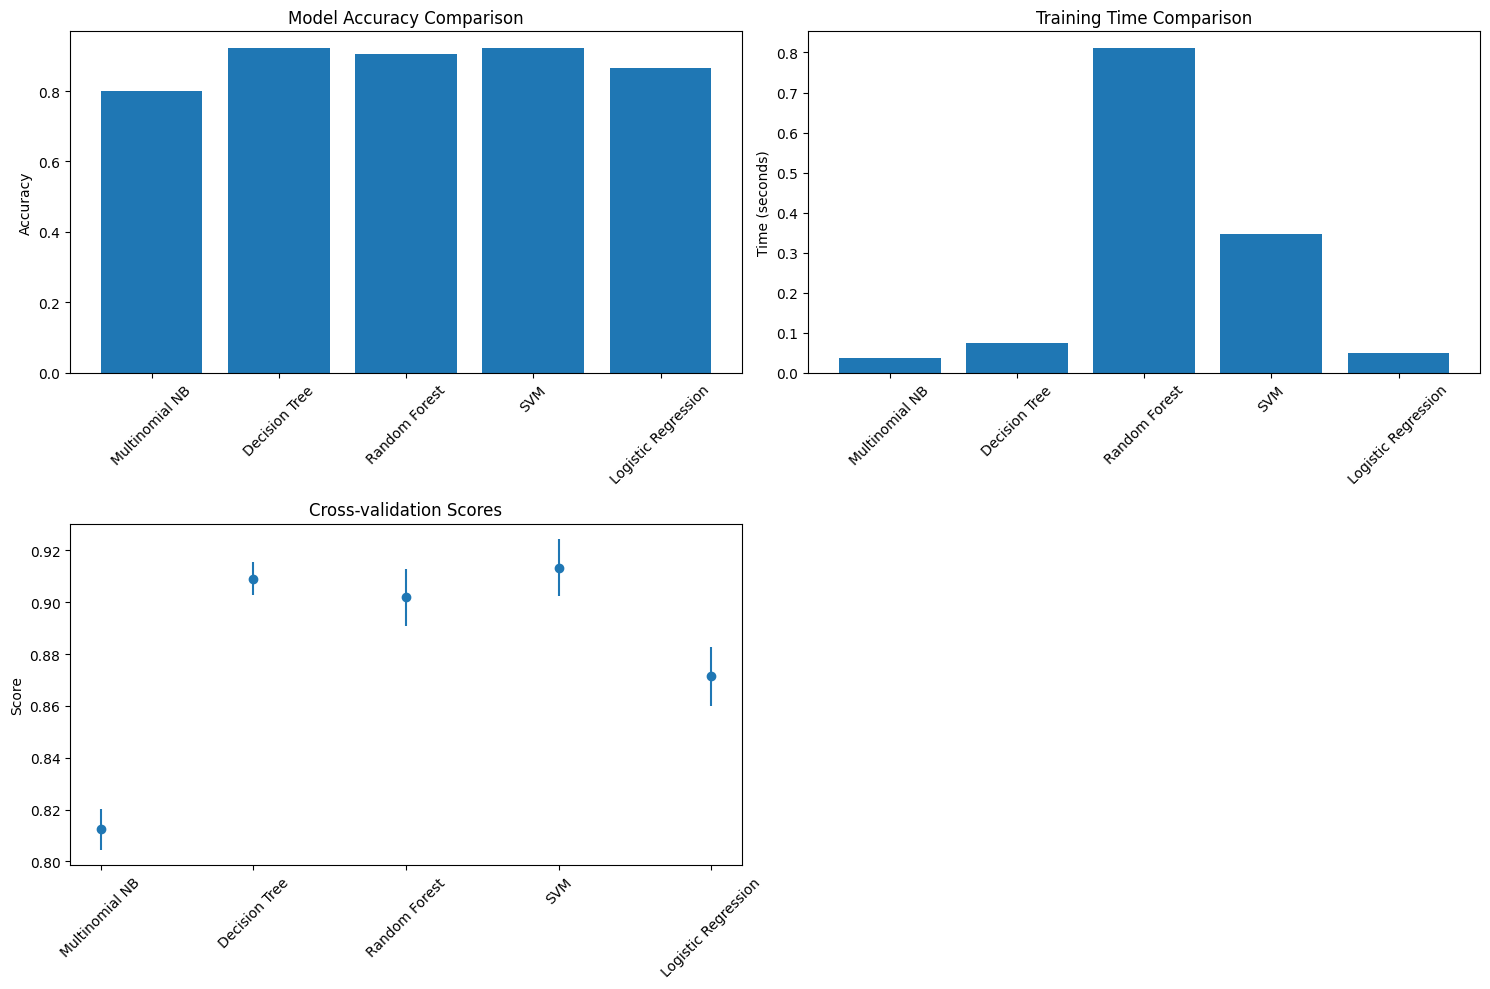

In [59]:
# Visualize results
def plot_benchmark_results(results: BenchmarkResults):
    # Set up the matplotlib figure
    plt.figure(figsize=(15, 10))

    # Plot accuracy comparison
    plt.subplot(2, 2, 1)
    accuracies = [metrics.accuracy for metrics in results.models.values()]
    plt.bar(results.models.keys(), accuracies)
    plt.title("Model Accuracy Comparison")
    plt.xticks(rotation=45)
    plt.ylabel("Accuracy")

    # Plot training time comparison
    plt.subplot(2, 2, 2)
    times = [metrics.training_time for metrics in results.models.values()]
    plt.bar(results.models.keys(), times)
    plt.title("Training Time Comparison")
    plt.xticks(rotation=45)
    plt.ylabel("Time (seconds)")

    # Plot cross-validation scores
    plt.subplot(2, 2, 3)
    cv_means = [
        np.mean(metrics.cross_val_scores) for metrics in results.models.values()
    ]
    cv_stds = [np.std(metrics.cross_val_scores) for metrics in results.models.values()]
    plt.errorbar(results.models.keys(), cv_means, yerr=cv_stds, fmt="o")
    plt.title("Cross-validation Scores")
    plt.xticks(rotation=45)
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()


# Plot the results
plot_benchmark_results(results)

In [60]:
# Save best performing model
best_model_name = max(results.models.items(), key=lambda x: x[1].accuracy)[0]
best_model = create_pipeline(classifiers[best_model_name])
best_model.fit(X_train, y_train)

import joblib

joblib.dump(best_model, "best_model.pkl")
print(
    f"Best performing model was {best_model_name} with accuracy {results.models[best_model_name].accuracy:.4f}"
)

Best performing model was SVM with accuracy 0.9233


In [61]:
# Saving all trained algorithm pipeline as pickle files

# Assuming 'classifiers' and 'results' are defined as in your original code
for name, clf in classifiers.items():
    pipeline = create_pipeline(clf)  # Recreate the pipeline for each model
    pipeline.fit(X_train, y_train)  # Train the pipeline

    # Save the trained model
    filename = f"{name.replace(' ', '_')}.pkl"  # Create filename (replace spaces with underscores)
    joblib.dump(pipeline, filename)
    print(f"Saved {name} to {filename}")

Saved Multinomial NB to Multinomial_NB.pkl
Saved Decision Tree to Decision_Tree.pkl
Saved Random Forest to Random_Forest.pkl
Saved SVM to SVM.pkl
Saved Logistic Regression to Logistic_Regression.pkl


In [62]:
# Test all saved models and benchmark their performance

import time

# Load all saved models
model_files = ['Multinomial_NB.pkl', 'Decision_Tree.pkl', 'Random_Forest.pkl', 'SVM.pkl', 'Logistic_Regression.pkl']
loaded_models = {}
for filename in model_files:
    loaded_models[filename[:-4]] = joblib.load(filename)  # Store with model name

# Input a new test case
single_test_case = [input("Enter your test case: ")]

# Benchmark each model
results = {}
for name, model in loaded_models.items():
    start_time = time.time()
    prediction = model.predict(single_test_case)
    end_time = time.time()
    results[name] = {'prediction': prediction[0], 'time': end_time - start_time}

# Display results
print(f'\nTest Case: {single_test_case[0]}')
for name, result in results.items():
    print(f'{name}: Prediction - {result["prediction"]}, Time - {result["time"]:.4f} seconds')

Enter your test case: Enter an invalid username

Test Case: Enter an invalid username
Multinomial_NB: Prediction - Neg, Time - 0.0022 seconds
Decision_Tree: Prediction - Neg, Time - 0.0019 seconds
Random_Forest: Prediction - Neg, Time - 0.0129 seconds
SVM: Prediction - Neg, Time - 0.0017 seconds
Logistic_Regression: Prediction - Neg, Time - 0.0013 seconds


In [63]:
import random

test_cases = [
    "This is a positive test case about great customer service.",
    "I am very unhappy with the product quality.",
    "The delivery was extremely late and I'm frustrated.",
    "I had a wonderful experience with your company.",
    "The software is buggy and crashes frequently.",
    "I love this product! It's amazing.",
    "I'm having trouble understanding the instructions.",
    "Your customer support team was very helpful.",
    "This is a neutral comment with no strong sentiment.",
    "The product is terrible and I regret buying it.",
    "I had a horrible experience with the customer service.",
    "This is the worst purchase I have ever made.",
    "I'm extremely dissatisfied with the product's performance.",
    "The company's policies are unfair and frustrating.",
    "I'm disappointed with the recent changes.",
    "The service was excellent and I highly recommend it.",
    "I'm not sure if I like this product yet.",
    "I'm experiencing technical difficulties.",
    "The price is too high for the quality.",
    "I'm satisfied with my purchase overall.",
    "This product exceeded my expectations.",
    "I would like to request a refund.",
    "I'm having a problem with my account.",
    "The website is slow and unresponsive.",
    "I'm impressed with the features and performance."
]

# Benchmark each model on all test cases
all_results = {}
for name, model in loaded_models.items():
    all_results[name] = []
    for test_case in test_cases:
        start_time = time.time()
        prediction = model.predict([test_case])  # Predict for single test case
        end_time = time.time()
        all_results[name].append({'prediction': prediction[0], 'time': end_time - start_time})

In [64]:
import numpy as np

# Calculate average prediction times
average_times = {}
for name, results in all_results.items():
    times = [result['time'] for result in results]
    average_times[name] = np.mean(times)

print("\nAverage Prediction Times:")
for name, avg_time in average_times.items():
    print(f"{name}: {avg_time:.4f} seconds")

# Update ground_truth with labels for new negative test cases
ground_truth = ['positive', 'negative', 'negative', 'positive', 'negative', 'positive', 'neutral', 'positive', 'neutral', 'negative', 'positive', 'neutral', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive']
ground_truth.extend(['negative'] * 5)  # Add labels for 5 new negative test cases (adjust as needed)

# Calculate accuracy for each model (updated)
accuracies = {}
for name, results in all_results.items():
    predictions = [result['prediction'] for result in results]
    correct_predictions = sum(1 for pred, truth in zip(predictions, ground_truth) if pred == truth)
    accuracies[name] = correct_predictions / len(predictions)  # Divide by len(predictions)

print("\nAccuracies:")
for name, accuracy in accuracies.items():
    print(f"{name}: {accuracy:.4f}")


Average Prediction Times:
Multinomial_NB: 0.0010 seconds
Decision_Tree: 0.0010 seconds
Random_Forest: 0.0074 seconds
SVM: 0.0011 seconds
Logistic_Regression: 0.0008 seconds

Accuracies:
Multinomial_NB: 0.0000
Decision_Tree: 0.0000
Random_Forest: 0.0000
SVM: 0.0000
Logistic_Regression: 0.0000


In [65]:
import pandas as pd
import numpy as np

def highlight_differences(data):
    first_col_values = data.iloc[:, 0]
    df = data.apply(lambda row: ['background-color: yellow' if val != first_col_values[row.name] else '' for val in row], axis=1, result_type='broadcast')
    return df

def color_predictions(val):
    if val == 'positive':
        color = 'background-color: green'  # Green background for positive
    elif val == 'negative':
        color = 'background-color: red'   # Red background for negative
    else:
        color = ''  # No background color for other cases
    return color

# Apply the styles to the DataFrame
subset_cols = rubric_df.columns[1:]
styled_rubric = rubric_df.style.apply(highlight_differences, subset=subset_cols, axis=None) \
                             .applymap(color_predictions, subset=subset_cols)

styled_rubric

<ipython-input-65-f1679f120e87>:20: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_rubric = rubric_df.style.apply(highlight_differences, subset=subset_cols, axis=None) \


,Test Case,Multinomial_NB,Decision_Tree,Random_Forest,SVM,Logistic_Regression
0,This is a positive test case about great customer service.,Pos,Pos,Pos,Pos,Pos
1,I am very unhappy with the product quality.,Pos,Pos,Pos,Pos,Pos
2,The delivery was extremely late and I'm frustrated.,Pos,Pos,Pos,Pos,Pos
3,I had a wonderful experience with your company.,Pos,Pos,Pos,Pos,Pos
4,The software is buggy and crashes frequently.,Pos,Pos,Pos,Pos,Pos
5,I love this product! It's amazing.,Pos,Pos,Pos,Pos,Pos
6,I'm having trouble understanding the instructions.,Pos,Pos,Pos,Pos,Pos
7,Your customer support team was very helpful.,Pos,Pos,Pos,Pos,Pos
8,This is a neutral comment with no strong sentiment.,Pos,Pos,Pos,Pos,Pos
9,The product is terrible and I regret buying it.,Pos,Pos,Pos,Pos,Pos
